In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import sys

# Determine the project root
current_path = Path.cwd().resolve()
root = current_path.parents[0]

# find modelling path
mod_path = root / "src" / "modelling"

# append path for custom function
sys.path.append(str(mod_path))

# load stationarity function
from stationarity_report import build_stationarity_html

In [2]:
# aini dfs
data_path = root / "data"
var_path = data_path / "processed" / "variables"
aini_df = pd.DataFrame()
vars = ["binary", "w0", "w1", "w2"]

aini_dfs = {}

for var in vars:
    df = pd.read_csv(var_path / f"{var}_AINI_variables.csv")

    # ensure types and order
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["normalized_AINI"] = pd.to_numeric(df["normalized_AINI"], errors="coerce")
    df = df.sort_values("date").reset_index(drop=True)

    # compute z-score: (x - mean) / std
    mean = df["normalized_AINI"].mean(skipna=True)
    std = df["normalized_AINI"].std(skipna=True)

    df["normalized_AINI_z"] = (df["normalized_AINI"] - mean) / std

    aini_dfs[var] = df

# target cols
target_cols_aini = ["normalized_AINI","EMA_02","EMA_08","normalized_AINI_z"]
aini_data_test = list()

# iterate through models and variables
for key, df in aini_dfs.items():
    for var in target_cols_aini:
        if var in df.columns:
            temp = pd.DataFrame({
                "Date": pd.to_datetime(df["date"]),
                "measure": f"{key}_{var}",
                "value": df[var].values
            })
            aini_data_test.append(temp)

# concatenate all partial dataframes
aini_data_test = pd.concat(aini_data_test, ignore_index=True)

aini_data_test

,Date,measure,value
0,2023-04-01,binary_normalized_AINI,0.000000
1,2023-04-02,binary_normalized_AINI,0.000000
2,2023-04-03,binary_normalized_AINI,0.000000
3,2023-04-04,binary_normalized_AINI,0.000000
4,2023-04-05,binary_normalized_AINI,0.000000
...,...,...,...
12491,2025-06-12,w2_normalized_AINI_z,0.108297
12492,2025-06-13,w2_normalized_AINI_z,2.046412
12493,2025-06-14,w2_normalized_AINI_z,0.108297
12494,2025-06-15,w2_normalized_AINI_z,0.108297


In [3]:
# fin data
fin_path = data_path / "raw" / "financial" / "full_daily_2023_2025.csv"
fin_data = pd.read_csv(fin_path)

# ensure types and order 
fin_data["Date"] = pd.to_datetime(fin_data["Date"], errors="coerce")
fin_data["Adj Close"] = pd.to_numeric(fin_data["Adj Close"], errors="coerce")
fin_data = fin_data.sort_values(["Ticker", "Date"]).reset_index(drop=True)

# log returns per Ticker: Δ log(Adj Close)
fin_data["log_return"] = (
    fin_data.groupby("Ticker")["Adj Close"]
            .transform(lambda s: np.log(s).diff())
)

# target col
target_fin = ["log_return"]
fin_data

# ensure types and order 
fin_data["Date"] = pd.to_datetime(fin_data["Date"], errors="coerce")
fin_data["Adj Close"] = pd.to_numeric(fin_data["Adj Close"], errors="coerce")
fin_data = fin_data.sort_values(["Ticker", "Date"]).reset_index(drop=True)

# log returns per Ticker: Δ log(Adj Close)
fin_data["log_return"] = (
    fin_data.groupby("Ticker")["Adj Close"]
            .transform(lambda s: np.log(s).diff())
)

# target col
target_fin = ["log_return"]
fin_data_test = pd.DataFrame()

# subset 
fin_data_test["Date"] = fin_data["Date"] 
fin_data_test["measure"] = fin_data["Ticker"] 
fin_data_test["value"] = fin_data["log_return"] 

fin_data_test

,Date,measure,value
0,2023-04-03,AAPL,NaN
1,2023-04-04,AAPL,-0.003255
2,2023-04-05,AAPL,-0.011354
3,2023-04-06,AAPL,0.005481
4,2023-04-10,AAPL,-0.016102
...,...,...,...
9719,2025-07-09,^SOX,0.004381
9720,2025-07-10,^SOX,0.007436
9721,2025-07-11,^SOX,-0.002103
9722,2025-07-14,^SOX,-0.008740


In [4]:
# vix data
vix_path = data_path / "processed" / "variables" / "log_growth_VIX.csv"
vix_data = pd.read_csv(vix_path)

# subset 
vix_data_test = pd.DataFrame()
vix_data_test["Date"] = pd.to_datetime(vix_data["date"])
vix_data_test["measure"] = "VIX"
vix_data_test["value"] = vix_data["log_growth_closed"]

vix_data_test

,Date,measure,value
0,2023-04-03,VIX,NaN
1,2023-04-04,VIX,0.023969
2,2023-04-05,VIX,0.004202
3,2023-04-06,VIX,-0.036290
4,2023-04-10,VIX,0.030508
...,...,...,...
563,2025-06-09,VIX,0.022990
564,2025-06-10,VIX,-0.012313
565,2025-06-11,VIX,0.018124
566,2025-06-12,VIX,0.043091


In [5]:
# concat all 
test_all = pd.concat([vix_data_test,fin_data_test,aini_data_test])
test_all = test_all.rename({"measure":"Measure","value":"Value"},axis=1)
test_all

,Date,Measure,Value
0,2023-04-03,VIX,NaN
1,2023-04-04,VIX,0.023969
2,2023-04-05,VIX,0.004202
3,2023-04-06,VIX,-0.036290
4,2023-04-10,VIX,0.030508
...,...,...,...
12491,2025-06-12,w2_normalized_AINI_z,0.108297
12492,2025-06-13,w2_normalized_AINI_z,2.046412
12493,2025-06-14,w2_normalized_AINI_z,0.108297
12494,2025-06-15,w2_normalized_AINI_z,0.108297


In [10]:
combined = build_stationarity_html(
    df=test_all,  # tidy df with Date, Measure, Value
    output_html= root / "reports/tables/stationarity_all_measures.html",
    save_combined_csv= root /"data/processed/variables/stationarity_all_measures.csv",
    save_combined_tex= root /"reports/tables/stationarity_all_measures.tex",
)


C:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\src\modelling\stationarity_report.py:35: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(s, regression=kpss_regression, nlags=kpss_nlags)
C:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\src\modelling\stationarity_report.py:35: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(s, regression=kpss_regression, nlags=kpss_nlags)
C:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\src\modelling\stationarity_report.py:35: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(s, regression=kpss_regression

C:\Users\PC\AppData\Local\Temp\ipykernel_20260\1117399972.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(s, regression="c", nlags="auto")


ADF p=0 | PP p=0 | KPSS p=0.1


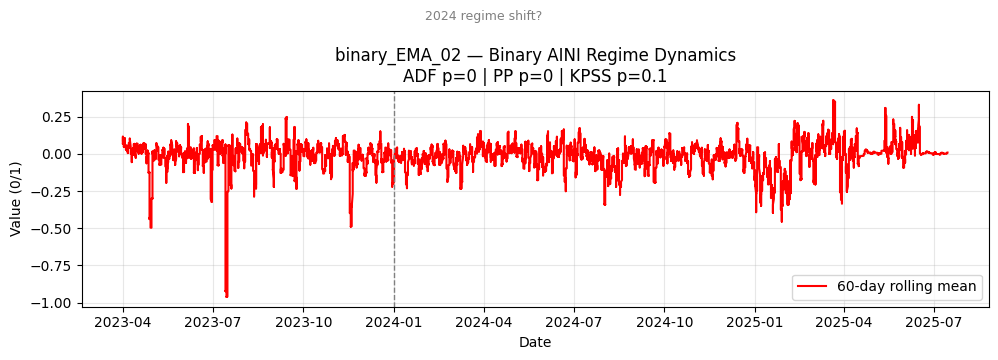

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import PhillipsPerron
df_bin = test_all.copy()
## === 1. Select your series ===
col = "binary_EMA_02"
df_bin = df_bin.sort_values("Date")

# === 2. Compute rolling mean ===
df_bin["rolling_mean"] = df_bin["Value"].rolling(window=40, min_periods=20, center=True).mean()

# === 3. Run tests for the full sample ===
s = df_bin["Value"].astype(float).dropna()
adf_stat, adf_p, *_ = adfuller(s, autolag="AIC")
pp = PhillipsPerron(s)
pp_stat, pp_p = pp.stat, pp.pvalue
kpss_stat, kpss_p, *_ = kpss(s, regression="c", nlags="auto")

print(f"ADF p={adf_p:.3g} | PP p={pp_p:.3g} | KPSS p={kpss_p:.3g}")

# === 4. Plot ===
fig, ax = plt.subplots(figsize=(10,4))
#ax.plot(df_bin["Date"], df_bin["Value"], lw=0.7, label="Binary AINI (0/1)", alpha=0.8)
ax.plot(df_bin["Date"], df_bin["rolling_mean"], color="red", lw=1.5, label="60-day rolling mean")

# highlight subperiods (2023–24 break)
ax.axvline(pd.Timestamp("2024-01-01"), color="grey", ls="--", lw=1)
ax.text(pd.Timestamp("2024-02-01"), 0.9, "2024 regime shift?", color="grey", fontsize=9)

ax.set(
    title=f"{col} — Binary AINI Regime Dynamics\n"
          f"ADF p={adf_p:.3g} | PP p={pp_p:.3g} | KPSS p={kpss_p:.3g}",
    xlabel="Date",
    ylabel="Value (0/1)"
)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()